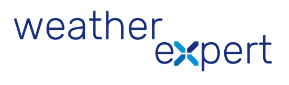

In [1]:
import pandas as pd
import plotly.express as px
import numpy as np
from datetime import datetime, timedelta
import ipywidgets as widgets
import requests, json
!pip install solarpy
from solarpy import irradiance_on_plane, solar_panel
from datetime import datetime
!pip install pgeocode
import pgeocode
from datetime import datetime
from shapely.geometry import Point
!pip install calfire-wildfires
import calfire_wildfires
import numpy as np
import pandas as pd


ModuleNotFoundError: No module named 'shapely'

### Load demand data

In [ ]:
path = "https://github.com/jrt560/data/raw/main/supermarket.csv"
demand_data = pd.read_csv(path)

demand_data.tail()
months = []
days = []
time_of_day = []

for i in range(0,np.shape(demand_data)[0]):
  temp = demand_data['date/time'][i]
  time_of_day.append(temp.split(' ')[-1])
  temp_month = temp.split('/')[0].lstrip(' ')
  months.append(int(temp_month))
  temp_day = temp.split('/')[1][0:2]
  days.append(int(temp_day))

demand_data['month']=months
demand_data['day']=days
demand_data['time_of_day']=time_of_day
demand_data = demand_data.drop(columns = ['Unnamed: 2'])
demand_data = demand_data.drop(columns = ['Unnamed: 3'])

demand_data.head()


,date/time,kwh,month,day,time_of_day
0,01/01 01:00:00,103.909147,1,1,01:00:00
1,01/01 02:00:00,102.220377,1,1,02:00:00
2,01/01 03:00:00,100.249745,1,1,03:00:00
3,01/01 04:00:00,98.198527,1,1,04:00:00
4,01/01 05:00:00,103.562145,1,1,05:00:00


## **User Inputs:**


In [ ]:
print("Please enter your zip code:")
zip = input()


Please enter your zip code:
90045


In [ ]:
print("Please enter number of solar panels:")
num_of_panels = input()

Please enter number of solar panels:
500


In [ ]:
print("Please enter in kWh battery size:")
user_supplied_battery_size = input()

Please enter in kWh battery size:
250


In [ ]:
print('Please enter current battery %: ')
battery_percent_input = input()

Please enter current battery %: 
97


### Get weather forecast data for zip code

In [ ]:
# converting the zip code into lat/lon coordinates for the weather API.

nomi = pgeocode.Nominatim('us')
zip_info = nomi.query_postal_code(zip)
zip_lat = zip_info.latitude
zip_lon = zip_info.longitude
print("This zip code corresponds to " + 
      str(zip_lat) + " latitude and " +
      str(zip_lon) + " longitude.")
print("\n")
print("Searching for 5-day forecast data for your location...")

This zip code corresponds to 33.9631 latitude and -118.3941 longitude.


Searching for 5-day forecast data for your location...


In [ ]:
# Finding the local weather data for the corresponding lat/lon coordinates.

# Enter your API key here

api_key = "0991b1584a6c341b59012416f50ce210"
base_url = "http://api.openweathermap.org/data/2.5/forecast?"

complete_url = base_url + "&lat=" + str(zip_lat) + "&lon=" + str(zip_lon)  + "&appid=" + api_key 

print(complete_url)

# get method of requests module
# return response object
response = requests.get(complete_url)
 
# json method of response object
# convert json format data into
# python format data
forecast_data = response.json()

print("\n")
print("Forecast data has been extracted for your location.")

http://api.openweathermap.org/data/2.5/forecast?&lat=33.9631&lon=-118.3941&appid=0991b1584a6c341b59012416f50ce210


Forecast data has been extracted for your location.


###Estimate battery capacity from daily sums of demand

In [ ]:
### ASSUMPTIONS
#1: assume battery capacity if the average daily demand
#daily_sums = demand_data.groupby(['month','day'])['kwh'].sum()
#battery_capacity_kW =np.mean(daily_sums)/24
#battery_capacity_kW



### Considering wildfires, make assumptions on minimum battery life for saftey

In [ ]:
### ASSUMPTIONS CONTINUED
### FIGURE OUT BATTERY MINIMUM LEVELS

#2: assume battery level can dip to 50% UNLESS there is a fire detected 
#3: now check for fire, if yes, maximize batter 

active_fire_data = calfire_wildfires.get_active_fires()
df_fire_data = pd.DataFrame.from_dict(active_fire_data)

geometries = []
names = []

if df_fire_data.empty:
    battery_min_level = 50
    print('no active wildfires, using battery minimum level of ' + str(battery_min_level) + '%')
else:
  for i in range(0,np.shape(df_fire_data)[0]):
    if df_fire_data.features[i]['properties']['IsActive']=='True':
      geometries.append(Point(df_fire_data.features[i]['properties']['Longitude'],df_fire_data.features[i]['properties']['Latitude']))
      names.append(df_fire_data.features[i]['properties']['Name'])
      battery_min_level = 100
      print(' active wildfires nearby, using battery maximum level of' + str(battery_min_level) + '%')

no active wildfires, using battery minimum level of 50%


### Get ranges of dates for forecasts

In [ ]:
#### GETTING DATA RANGES
start_forecast_date = datetime.strptime(forecast_data['list'][0]['dt_txt'], '%Y-%m-%d %H:%M:%S')
end_forecast_date = datetime.strptime(forecast_data['list'][-1]['dt_txt'], '%Y-%m-%d %H:%M:%S')
range_all_day_times = pd.date_range(start_forecast_date,end_forecast_date,freq='1H')
range_forecast_times = pd.date_range(start_forecast_date,end_forecast_date,freq='3H')


### Start looped calculations

In [ ]:

### LOOP GENERATION
battery_level = np.round(float(user_supplied_battery_size)*(float(battery_percent_input)/100),2)
print('starting battery start amount: ' + str(battery_level))

battery_levels_out = []
solar_power_generated = []
estimated_demand = []
rainfall_out = []
cloudiness_out = []

for i in range(0,np.shape(range_all_day_times)[0]):
  input_date = str(range_all_day_times[i])
  #this line determines which forecast to use, finds the closest date/time
  index_forecast = range_forecast_times.searchsorted(range_all_day_times[i])
  temp_forecast_data = forecast_data['list'][index_forecast]
  cloudiness = temp_forecast_data["clouds"]["all"]
  print('it will be this cloudy: ' + str(cloudiness) + '%')
  try: 
    temp_forecast_data['rain']['3h']
  except:
    rainfall = 0
    print('it is not going to rain')
  else:
    rainfall = temp_forecast_data['rain']['3h']
    print('it is going to rain')
  rainfall_out.append(rainfall)
  year_forecast = int(input_date[0:4])
  month_forecast = int(input_date[5:7])
  day_forecast = int(input_date[8:10])
  time_of_day_forecast = (input_date[11:])
  if time_of_day_forecast == '00:00:00':
    time_of_day_adjust = '24:00:00'
  else:
    time_of_day_adjust = time_of_day_forecast

  print('finding matching month/day/time for: ' + str(input_date)) 
  demand_kwh = np.round(demand_data[(demand_data['month']==month_forecast)&(demand_data['day']==day_forecast)&(demand_data['time_of_day']==time_of_day_adjust)]['kwh'].values[0],2)
  estimated_demand.append(demand_kwh)
  #demand_estimated
  print('estimated demand: ' + str(demand_kwh) + ' kWh')
  panel = solar_panel(2.1, 0.2, id_name='example')  # surface, efficiency and name
  panel.set_orientation(np.array([0, 0, -1]))  # upwards
  panel.set_position(zip_lat, zip_lon, 0)  # NYC latitude, longitude, altitude
  panel.set_datetime(datetime(year_forecast, month_forecast, day_forecast, int(time_of_day_forecast[0:2]), 0))  # Christmas Day!
  one_panel_energy_W = panel.power()
  all_panels_energy_kWh_no_clouds = np.round((one_panel_energy_W*float(num_of_panels))/1000,2)
  if rainfall > 0:
    cloudiness = 100  
  cloudiness_out.append(cloudiness)
  all_panels_energy_kWh_with_clouds = np.round((all_panels_energy_kWh_no_clouds * (100-cloudiness)/100),2)
  print('estimated solar power generation without clouds: ' + str(all_panels_energy_kWh_no_clouds) + ' kWh')
  print('estimated solar power generation with clouds: ' + str(all_panels_energy_kWh_with_clouds) + ' kWh')
  solar_power_generated.append(all_panels_energy_kWh_with_clouds)
  estimated_new_battery_level = np.round((battery_level - demand_kwh + all_panels_energy_kWh_with_clouds),2)
  #print(str(estimated_new_battery_level))
  #print(str(float(user_supplied_battery_size)*(battery_min_level/100)))
  if estimated_new_battery_level < float(user_supplied_battery_size)*(battery_min_level/100):
    print('battery cannot being used to supply energy, demand exceeds solar generation to a level that is below a safe minimum')
    battery_level = battery_level + all_panels_energy_kWh_with_clouds
    battery_level = np.min([(battery_level),float(user_supplied_battery_size)])

    battery_levels_out.append(battery_level)


  else:
    print('battery and solar can be used to supply energy, battery is above the safe minimum')

    battery_level = np.min([(estimated_new_battery_level),float(user_supplied_battery_size)])

    battery_levels_out.append(battery_level)
  print('----------------------------------------------------')







starting battery start amount: 242.5
it will be this cloudy: 20%
it is not going to rain
finding matching month/day/time for: 2022-12-21 00:00:00
estimated demand: 139.67 kWh
estimated solar power generation without clouds: 0.0 kWh
estimated solar power generation with clouds: 0.0 kWh
battery cannot being used to supply energy, demand exceeds solar generation to a level that is below a safe minimum
----------------------------------------------------
it will be this cloudy: 14%
it is not going to rain
finding matching month/day/time for: 2022-12-21 01:00:00
estimated demand: 109.87 kWh
estimated solar power generation without clouds: 0.0 kWh
estimated solar power generation with clouds: 0.0 kWh
battery and solar can be used to supply energy, battery is above the safe minimum
----------------------------------------------------
it will be this cloudy: 14%
it is not going to rain
finding matching month/day/time for: 2022-12-21 02:00:00
estimated demand: 100.67 kWh
estimated solar power g

In [ ]:
output_df = pd.DataFrame({'dates':range_all_day_times,'battery level': battery_levels_out,
                          'solar power generated':solar_power_generated,'estimated demand':estimated_demand,
                          'cloudiness percent': cloudiness_out,'rainfall amount':rainfall_out})

### Generate plots from ouputs

In [ ]:
from plotly.subplots import make_subplots
import plotly.graph_objects as go

fig = make_subplots(
    rows=2, cols=1,
    subplot_titles=("Cloudiness", "Power Generation, Battery Level, and Demand"))

fig.add_trace(go.Scatter(x=output_df['dates'], y=output_df['cloudiness percent'], name='Cloudiness'),
              row=1, col=1)

fig.add_trace(go.Scatter(x=output_df['dates'], y=output_df['battery level'], name='Battery Level'), 
              row=2, col=1)

fig.add_trace(go.Scatter(x=output_df['dates'], y=output_df['solar power generated'], name='Solar Power Generated'),
              row=2, col=1)

fig.add_trace(go.Scatter(x=output_df['dates'], y=output_df['estimated demand'], name='Estimated Demand'),
              row=2, col=1)


fig.update_layout(height=800, width=800,showlegend=True
                  )
fig['layout']['yaxis']['title']='%'
fig['layout']['yaxis2']['title']='kW'
fig.show()

In [ ]:
fig.write_html("demo_outputs_for_Nexus_forecast_system.html")


### STOP HERE FOR CODE, START STREAMLIT CONVERSION

In [1]:
!pip install streamlit==1.15.2
!pip install pyngrok
!pip install solarpy
!pip install pgeocode
!pip install calfire-wildfires
!pip install pillow

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 9.2 MB 4.9 MB/s 
     |████████████████████████████████| 78 kB 7.4 MB/s 
     |████████████████████████████████| 4.7 MB 56.6 MB/s 
     |████████████████████████████████| 237 kB 71.1 MB/s 
     |████████████████████████████████| 182 kB 76.5 MB/s 
     |████████████████████████████████| 164 kB 74.0 MB/s 
     |████████████████████████████████| 62 kB 1.4 MB/s 
     |████████████████████████████████| 51 kB 3.0 MB/s 
  Created wheel for validators: filename=validators-0.20.0-py3-none-any.whl size=19581 sha256=990bb6a7f9e82ced34ec187c627293fc6b924909c7730498d24e0bb7513a8c95
  Stored in directory: /root/.cache/pip/wheels/19/09/72/3eb74d236bb48bd0f3c6c3c83e4e0c5bbfcbcad7c6c3539db8
Successfully built validators
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 761 kB 5.

In [ ]:
%%writefile app.py
import streamlit as st

st.title('Welcome to Weather Expert - a Nexus Forcasting System')
st.subheader('Please enter the following information')
zip = st.number_input('Enter your zipcode:',0,10000000000,1)
num_of_panels = st.number_input('Enter how many solar panels you have:',0,10000000000,1)
user_supplied_battery_size = st.number_input('Enter your battery size in kWh:',0,10000000000,1)
battery_percent_input = st.slider('Enter your current battery percentage:',min_value=0,max_value=100)
running = st.button('Run Program')

import pandas as pd
import plotly.express as px
import numpy as np
from datetime import datetime, timedelta
import ipywidgets as widgets
import requests, json
from solarpy import irradiance_on_plane, solar_panel
from datetime import datetime
import pgeocode
from datetime import datetime
from shapely.geometry import Point
import calfire_wildfires
import numpy as np
import pandas as pd

path = "https://github.com/jrt560/data/raw/main/supermarket.csv"
demand_data = pd.read_csv(path)

demand_data.tail()
months = []
days = []
time_of_day = []

for i in range(0,np.shape(demand_data)[0]):
  temp = demand_data['date/time'][i]
  time_of_day.append(temp.split(' ')[-1])
  temp_month = temp.split('/')[0].lstrip(' ')
  months.append(int(temp_month))
  temp_day = temp.split('/')[1][0:2]
  days.append(int(temp_day))

demand_data['month']=months
demand_data['day']=days
demand_data['time_of_day']=time_of_day
demand_data = demand_data.drop(columns = ['Unnamed: 2'])
demand_data = demand_data.drop(columns = ['Unnamed: 3'])

demand_data.head()

if running == 1:
  # converting the zip code into lat/lon coordinates for the weather API.

  nomi = pgeocode.Nominatim('us')
  zip_info = nomi.query_postal_code(zip)
  zip_lat = zip_info.latitude
  zip_lon = zip_info.longitude
  
  # Finding the local weather data for the corresponding lat/lon coordinates.

  # Enter your API key here

  api_key = "0991b1584a6c341b59012416f50ce210"
  base_url = "http://api.openweathermap.org/data/2.5/forecast?"

  complete_url = base_url + "&lat=" + str(zip_lat) + "&lon=" + str(zip_lon)  + "&appid=" + api_key 

  # get method of requests module
  # return response object
  response = requests.get(complete_url)
 
  # json method of response object
  # convert json format data into
  # python format data
  forecast_data = response.json()

  ### ASSUMPTIONS
  #1: assume battery capacity if the average daily demand
  #daily_sums = demand_data.groupby(['month','day'])['kwh'].sum()
  #battery_capacity_kW =np.mean(daily_sums)/24
  #battery_capacity_kW
  
  ### ASSUMPTIONS CONTINUED
  ### FIGURE OUT BATTERY MINIMUM LEVELS

  #2: assume battery level can dip to 50% UNLESS there is a fire detected 
  #3: now check for fire, if yes, maximize battery 

  active_fire_data = calfire_wildfires.get_active_fires()
  df_fire_data = pd.DataFrame.from_dict(active_fire_data)

  geometries = []
  names = []

  if df_fire_data.empty:
    battery_min_level = 50
  else:
    for i in range(0,np.shape(df_fire_data)[0]):
      if df_fire_data.features[i]['properties']['IsActive']=='True':
        geometries.append(Point(df_fire_data.features[i]['properties']['Longitude'],df_fire_data.features[i]['properties']['Latitude']))
        names.append(df_fire_data.features[i]['properties']['Name'])
        battery_min_level = 100

  #### GETTING DATA RANGES
  start_forecast_date = datetime.strptime(forecast_data['list'][0]['dt_txt'], '%Y-%m-%d %H:%M:%S')
  end_forecast_date = datetime.strptime(forecast_data['list'][-1]['dt_txt'], '%Y-%m-%d %H:%M:%S')
  range_all_day_times = pd.date_range(start_forecast_date,end_forecast_date,freq='1H')
  range_forecast_times = pd.date_range(start_forecast_date,end_forecast_date,freq='3H')

  ### LOOP GENERATION
  battery_level = np.round(float(user_supplied_battery_size)*(float(battery_percent_input)/100),2)

  battery_levels_out = []
  solar_power_generated = []
  estimated_demand = []
  rainfall_out = []
  cloudiness_out = []

  for i in range(0,np.shape(range_all_day_times)[0]):
    input_date = str(range_all_day_times[i])
    #this line determines which forecast to use, finds the closest date/time
    index_forecast = range_forecast_times.searchsorted(range_all_day_times[i])
    temp_forecast_data = forecast_data['list'][index_forecast]
    cloudiness = temp_forecast_data["clouds"]["all"]
    try: 
      rainfall = temp_forecast_data['rain']['3h']
    except:
      rainfall = 0
    else:
      rainfall = temp_forecast_data['rain']['3h']
    rainfall_out.append(rainfall)
    year_forecast = int(input_date[0:4])
    month_forecast = int(input_date[5:7])
    day_forecast = int(input_date[8:10])
    time_of_day_forecast = (input_date[11:])
    if time_of_day_forecast == '00:00:00':
      time_of_day_adjust = '24:00:00'
    else:
      time_of_day_adjust = time_of_day_forecast
    demand_kwh = np.round(demand_data[(demand_data['month']==month_forecast)&(demand_data['day']==day_forecast)&(demand_data['time_of_day']==time_of_day_adjust)]['kwh'].values[0],2)
    estimated_demand.append(demand_kwh)
    #demand_estimated
    panel = solar_panel(2.1, 0.2, id_name='example')  # surface, efficiency and name
    panel.set_orientation(np.array([0, 0, -1]))  # upwards
    panel.set_position(zip_lat, zip_lon, 0)  # NYC latitude, longitude, altitude
    panel.set_datetime(datetime(year_forecast, month_forecast, day_forecast, int(time_of_day_forecast[0:2]), 0))  # Christmas Day!
    one_panel_energy_W = panel.power()
    all_panels_energy_kWh_no_clouds = np.round((one_panel_energy_W*float(num_of_panels))/1000,2)
    if rainfall > 0:
      cloudiness = 100  
    cloudiness_out.append(cloudiness)
    all_panels_energy_kWh_with_clouds = np.round((all_panels_energy_kWh_no_clouds * (100-cloudiness)/100),2)
    solar_power_generated.append(all_panels_energy_kWh_with_clouds)
    estimated_new_battery_level = np.round((battery_level - demand_kwh + all_panels_energy_kWh_with_clouds),2)
    if estimated_new_battery_level < float(user_supplied_battery_size)*(battery_min_level/100): 
      battery_level = battery_level + all_panels_energy_kWh_with_clouds
      battery_level = np.min([(battery_level),float(user_supplied_battery_size)])
      battery_levels_out.append(battery_level)
    else:
      battery_level = np.min([(estimated_new_battery_level),float(user_supplied_battery_size)])
      battery_levels_out.append(battery_level)
  output_df = pd.DataFrame({'dates':range_all_day_times,'battery level': battery_levels_out,
                          'solar power generated':solar_power_generated,'estimated demand':estimated_demand,
                          'cloudiness percent': cloudiness_out,'rainfall amount':rainfall_out})
  
  from plotly.subplots import make_subplots
  import plotly.graph_objects as go

  fig = make_subplots(
      rows=2, cols=1,
      subplot_titles=("Cloudiness", "Power Generation, Battery Level, and Demand"))

  fig.add_trace(go.Scatter(x=output_df['dates'], y=output_df['cloudiness percent'], line_color='#abcae4', name='Cloudiness'),
                row=1, col=1)

  fig.add_trace(go.Scatter(x=output_df['dates'], y=output_df['battery level'], line_color='#619bcc', name='Battery Level'), 
                row=2, col=1)

  fig.add_trace(go.Scatter(x=output_df['dates'], y=output_df['solar power generated'], line_color='#316a9a', name='Solar Power Generated'),
                row=2, col=1)

  fig.add_trace(go.Scatter(x=output_df['dates'], y=output_df['estimated demand'], line_color='#193750', name='Estimated Demand'),
                row=2, col=1)


  fig.update_layout(height=800, width=750,showlegend=True,
                   )
  fig['layout']['yaxis']['title']='%'
  fig['layout']['yaxis2']['title']='kW'
  fig.show()

  st.plotly_chart(fig)















Overwriting app.py


In [ ]:
!npm install localtunnel

npm WARN saveError ENOENT: no such file or directory, open '/content/package.json'
npm WARN enoent ENOENT: no such file or directory, open '/content/package.json'
npm WARN content No description
npm WARN content No repository field.
npm WARN content No README data
npm WARN content No license field.

+ localtunnel@2.0.2
updated 1 package and audited 36 packages in 2.007s

3 packages are looking for funding
  run `npm fund` for details

found 0 vulnerabilities



In [ ]:
#!ngrok authtoken YOUR_AUTH_TOKEN

Authtoken saved to configuration file: /root/.ngrok2/ngrok.yml


In [ ]:
!streamlit run /content/app.py #&>/content/logs.txt &

Traceback (most recent call last):
  File "/usr/local/bin/streamlit", line 5, in <module>
    from streamlit.web.cli import main
  File "/usr/local/lib/python3.8/dist-packages/streamlit/__init__.py", line 55, in <module>
    from streamlit.delta_generator import DeltaGenerator as _DeltaGenerator
  File "/usr/local/lib/python3.8/dist-packages/streamlit/delta_generator.py", line 38, in <module>
    from streamlit import config, cursor, env_util, logger, runtime, type_util, util
  File "/usr/local/lib/python3.8/dist-packages/streamlit/cursor.py", line 18, in <module>
    from streamlit.runtime.scriptrunner import get_script_run_ctx
  File "/usr/local/lib/python3.8/dist-packages/streamlit/runtime/__init__.py", line 16, in <module>
    from streamlit.runtime.runtime import Runtime as Runtime
  File "/usr/local/lib/python3.8/dist-packages/streamlit/runtime/runtime.py", line 26, in <module>
    from streamlit.proto.BackMsg_pb2 import BackMsg
  File "/usr/local/lib/python3.8/dist-packages/stre

In [ ]:
!npx localtunnel --port 8501

npx: installed 22 in 7.423s
your url is: https://easy-items-shop-35-229-130-4.loca.lt
^C
